# Creating a Neural Network from Target
Hello!  This in Matt's working tutorial for creating neural networks from Images.

## Step 1: Load nessecary modules

In [5]:
# Add python modules
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications.xception import preprocess_input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Input, LSTM, Dense
from keras.models import Model

#from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from copy import deepcopy

# Add parent directory for custom modules
from sys import path as sysPath
sysPath.append('../')
sysPath.append('../Machine_Score/')

# Load custom modules that simr has loaded
import main_SIMR as simr
gm = simr.gm
im = simr.im
ic = simr.ic
ms = simr.ms
sa = simr.sa
dc = simr.ms.dc

simr.test()
gm.test()
im.test()
ic.test()
ms.test()
dc.test()
sa.test()

SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew's information module for SPAM
IC: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DC: Hi!  You're in direct_image_compare.py
SA: Hi!  You're in Matthew's Main program for score analysis!


___
## Step 2: Load Target and single Run Info class
Needed for loading the target image and running through models later.
This is mostly to check I'm reading data from the model directories correctly.

In [6]:
tDir = '../targetDir'
tDir = gm.validPath(tDir)

tInfo = im.target_info_class( targetDir = tDir, printAll=False)
if tInfo.status == False:
    print("WARNING: target info class bad")
else:
    print("Target Good!")

# Get run info class
rInfo = tInfo.getRunInfo( rID='run_0000' )

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))

Target Good!
Run 'run_0000' Good!


(60, 40)
[40 60]


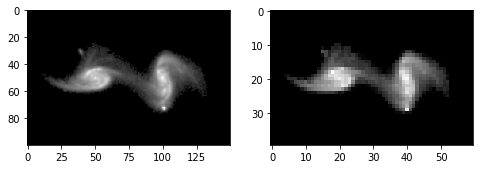

In [7]:
# Get target image and change to desired size
to_size = (60, 40) # (width, height) 
tImg = tInfo.getTargetImage( 'zoo_2' )
tImg2 = cv2.resize( tImg, to_size  )

print( to_size )
print( np.flip( to_size ) )

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(tImg, cmap='gray')
plt.subplot(122)
plt.imshow(tImg2, cmap='gray')

Scores: 502 
Images:  (502, 40, 60)
Flat Shape:  (502, 2400)


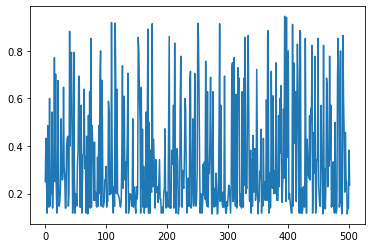

In [8]:
# This function iterates through the models of a target directory, reads and collects model images.
def gatherModelImages( tInfo, image_name = 'zoo_0', to_size = (60, 40) ):

    runDirList = tInfo.iter_runs()
    nRuns = len(runDirList)
    
    images = []
    scores = []

    if mpi_size == 1:
        for i, rDir in enumerate(runDirList):
            rInfo = im.run_info_class( runDir = rDir, printBase = tInfo.printAll   )
            if tInfo.printAll and rInfo.status == False: 
                gm.tabprint( '%s - %s' % (rInfo.status, rDir ) )
                continue
            rId = rInfo.get('run_id')

            s = rInfo.get('zoo_merger_score')
            img = rInfo.getModelImage(image_name)
            
            if s != None and type(img) != type(None):
                images.append( img )
                scores.append( float(s) )
            
            print( "%d / %d " % (i, len(runDirList) ), end='\r' )
        
            if i > 500:
                break

    else:
        print("WARNING: IM: Target.gatherRunInfos:  initializing run directories not available in MPI environment.")
        gm.tabprint(self.get('target_id'))
    
    n = len(scores)
    Y = np.array( scores )
    X = np.zeros( ( n, to_size[1], to_size[0] ) )  # NOTE: First index is how to change image for later nueral network training
    
    for i in range(n):
        X[i,:,:] = cv2.resize( images[i], to_size )
        
    
    return X, Y

tInfo.printAll = True
mpi_size = 1

X_raw, Y_raw = gatherModelImages( tInfo, 'zoo_2', to_size )

print( "Scores: %d " % len(Y_raw) )
print( "Images: " , X_raw.shape )

# Adjust images for neural networks

def flatten_images( X ):
    
    flat_size = X[0,:,:].size
    n = X.shape[0]
    
    X_new = np.reshape( X, (n,-1) )
    
    return( X_new )
            
X_flat = flatten_images( X_raw )
print("Flat Shape: ", X_flat.shape)

# Shuffle images randomly
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p,:], b[p]

X_mixed, Y_mixed = unison_shuffled_copies( X_flat, Y_raw )
plt.plot(Y_mixed)



In [9]:
print("Before Mean / Std: %f / %f " % ( np.mean(X_mixed), np.std(X_mixed) ) )

# Preprocess

n = X_mixed.shape[0]
X = np.zeros(X_mixed.shape)
Y = Y_mixed

for i in range( n ):
    X[i,:] = preprocess_input( np.expand_dims( X_mixed[i,:], axis=0 ) )
    
print("After Mean / Std: %f / %f " % ( np.mean(X), np.std(X) ) )

Before Mean / Std: 0.049743 / 0.134864 
After Mean / Std: -0.999610 / 0.001058 


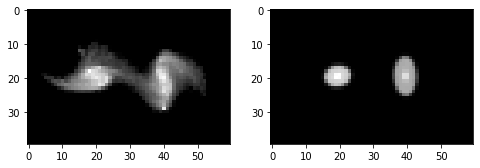

In [10]:
# Ensure image was flatten correctly and can be recovered
mImg = X[0,:].reshape(( to_size[1], to_size[0] ))
mImg = ((X[0,:] / 2)+0.5).reshape(( to_size[1], to_size[0] ))
#mImg = sc.inverse_transform(X[0,:]).reshape(( to_size[1], to_size[0] ))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(tImg2, cmap='gray')
plt.subplot(122)
plt.imshow(mImg, cmap='gray')

# Create a Single-Layer Nueral Network

In [12]:
# single layer regression model
def slr_1( input_shape, printAll = False, drop = None ):
    
    if printAll:
        print(input_shape)
        print(input_shape[1])
    
    model = keras.Sequential()
    
    model.add( keras.layers.Dense( 1,
        activation='sigmoid',
        input_shape=[input_shape[1]] ) )
    
    if drop != None:
        model.add(keras.layers.Dropout(drop))
    
    model.compile( loss='mean_squared_error',
        optimizer=tf.keras.optimizers.RMSprop(0.001),
        metrics=['mse'] 
    )
    
    return model

model = slr_1( X.shape, printAll = True )
model.summary()

#view_weights(model, 0)

(502, 2400)
2400
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2401      
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
def view_mse( history ):
    
    plt.clf()
    plt.cla()
    
    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()



def view_weights( model, i = None, saveLoc = None ):
    
    #Clear graph
    clear_output(wait=True)
    
    weights = model.get_weights()[0]
    l1 = weights[:,0]
    l1 = np.reshape( l1, ( to_size[1], to_size[0] ) )
    
    plt.imshow(l1)
    if i != None:
        plt.title(i)
        
    if saveLoc != None:
        plt.savefig( saveLoc )
        
    plt.show()
    

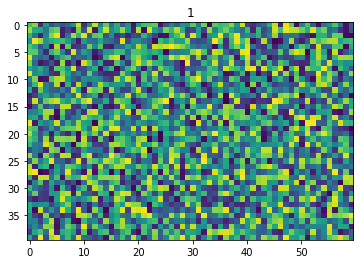

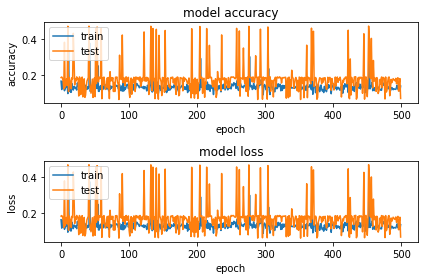

In [14]:
# Train once to view improvement
batch_size = 25
epochs = 500
history = model.fit(X, Y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split = 0.2)
#view_weights(model, 1, saveLoc = '../../weights/1.png')
view_mse(history)

In [16]:
for i in range(2,250):
    #break
    batch_size = 25
    epochs = 500
    history = model.fit(X, Y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2)
    #view_weights(model,i, saveLoc = '../../weights/%d.png' % i)
    #print(i)
    #view_mse(history)

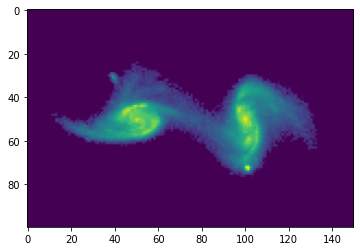

In [17]:
plt.imshow(tImg)

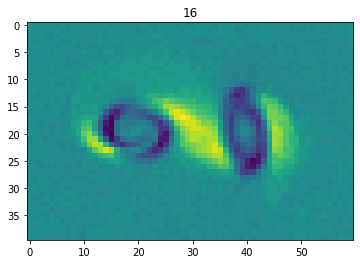

In [23]:
view_weights(model,i)